## Pet Friendly Travels

### An analysis of pet friendly accommodation listings around the globe.

The impetus for the analysis came from planning a road trip around Europe. This time I’m going to take my dog with me. Will it be a headache to find a place to stay? From this question I moved further and enquired whether pets are equally welcomed in different parts of the world. 

This notebook describes some analysis of the data I gathered on Airbnb.com. The goal is to find the most pet friendly countries to travel with a pet based on the ease of accommodation search.

#### Preliminaries
The first thing we need to do is to import Python libraries — pandas and matplotlib. I also use the humanize library to convert large numbers to a friendly text representation.

In [33]:
from __future__ import division
import pandas as pd
import matplotlib.pyplot as plt
import humanize

I'll skip the data gathering step. I used a CSV file with the list of countries and regions to parse Airbnb.com website and saved the data as a sqlite dictionary. That is why I'm going to use the sqlitedict library here.

In [34]:
from sqlitedict import SqliteDict
db = SqliteDict('./pet_friendly.sqlite')

The plots in this document are made using matplotlib’s ggplot style.

In [35]:
import matplotlib
%matplotlib inline  
matplotlib.style.use('fivethirtyeight')
# print plt.style.available

### Data overview
Next we read in data from the database and take a look at what we're working with.

In [36]:
def read_db_in_pandas(db):
    """ Read the DB."""
    # Transpose data to have keys as index.
    df = pd.DataFrame(dict(db)).T

    # Remove rows with no data for a country.
    df = df[df['apt_total'] != 0]

    # Convert columns into numbers.
    df = df.convert_objects(convert_numeric=True)
    
    return df

df = read_db_in_pandas(db)
print ("We have {0} countries in the dataset."
       .format(len(db)))
print ("{0} countries have no listings published."
       .format(len(db) - len(df)))
print ("We are left with {0} countries for closer examination."
       .format(len(df)))
print "\nBelow is a random sample of the DataFrame:"
df.sample(n=5)

We have 249 countries in the dataset.
18 countries have no listings published.
We are left with 231 countries for closer examination.

Below is a random sample of the DataFrame:


,apt_pets,apt_pets_price,apt_total,apt_total_price,country_code,region
Mauritania,5,39,12,44,MRT,Africa
Marshall Islands,0,NaN,1,12,MHL,Oceania
South Sudan,0,NaN,4,88,SSD,Africa
Cameroon,22,65,105,57,CMR,Africa
Djibouti,0,NaN,3,155,DJI,Africa


I collected data on total number of listings located in each country ('apt_total') and number of pet friendly listings ('apt_pets'), or in short PFL.  
I also parsed the average price per night in both categories ('apt_total_price' & 'apt_pets_price'). 

Let's examine the world!

In [37]:
# Number of listings.
apt_sum = df['apt_total'].sum()

# Number of PFL.
pets_sum = df['apt_pets'].sum()

# Share of PFL around the globe.
pets_share = round(pets_sum / apt_sum * 100)
print ("There are {0} listings all over the world on Airbnb."
       .format(humanize.intword(apt_sum)))
print ("Pets would be welcomed only in {0}% of all listings."
       .format(int(pets_share)))

There are 1.9 million listings all over the world on Airbnb.
Pets would be welcomed only in 21% of all listings.


In [38]:
# Make a histogram 
#df_sorted = [df['apt_total'](df['apt_total'] / df['apt_total'].sum()) * 100]

# df_min = df[df['apt_total'] < 1000]
# len(df_min)
# plt.figure();
# df['apt_total'].plot(kind='hist')
# plt.show()

In [39]:
# Average price per night.
price_mean = round(df['apt_total_price'].mean())
pet_mean = round(df['apt_pets_price'].mean())

# Difference in price.
diff = round((price_mean - pet_mean) / price_mean * 100)
    
print ("The average price for a listing is ${0} per night."
       .format(int(price_mean)))
print ("A PFL would cost {0}% less, or ${1}."
       .format(int(diff), int(pet_mean)))

The average price for a listing is $126 per night.
A PFL would cost 10% less, or $114.


A quick glance at the whole dataset reveals that countries with few listings do not tell much about their attitude towards pets. Let's look at the top-5 friendliest countries.

In [40]:
# Percent of PFL 
compare = df['apt_pets']/df['apt_total']
compare.sort(ascending=False)
print "The friendliest countries:"
compare[:5]

The friendliest countries:


Western Sahara               1.000000
Wallis and Futuna            1.000000
Saint Pierre and Miquelon    0.800000
Guinea                       0.615385
Antarctica                   0.588235
dtype: float64

This chart tells us that 100% of listings in Western Sahara and Wallis and Futuna are pet friendly. But that's only because there is only one listing in the country, and pets are allowed there.

In [41]:
df.loc[['Western Sahara', 'Wallis and Futuna']][['apt_total', 'apt_pets']]

,apt_total,apt_pets
Western Sahara,1,1
Wallis and Futuna,1,1


Is Antarctica in the top-5 chart? Do penguins rent out their nests?  
Apparently, there's some mistake on Airbnb. 17 listings located in different parts of the globe were mistakenly marked off as based in Antarctica.

I'll fix the dataset a bit for further analysis.

In [42]:
# Add a threshold of 30 listings.
df_cut = df[df['apt_total'] > 30]

# Remove Antarctica.
df_cut = df_cut[df_cut.index != 'Antarctica']

print ("These changes leave us {0} countries to examine."
       .format(len(df_cut)))
print "\nTop-5 countries with the highest ratio of PFL:"

compare = df_cut['apt_pets'] / df_cut['apt_total']
compare.sort(ascending=False)
compare[:5]

These changes leave us 180 countries to examine.

Top-5 countries with the highest ratio of PFL:


Andorra         0.459259
Burkina Faso    0.381818
Italy           0.374907
Slovakia        0.373232
El Salvador     0.372159
dtype: float64

Guinea is the most welcoming country where 61.5% of 13 listings are ready to accommodate a pet.  
Andorra with 46% of 405 listings is on the second place.
Only in Palau, no one is willing to host a pet. I'll have to exclude this country from my road trip for now. 

In [43]:
print "5 contries with the lowest percent of "
compare[-5:]

5 contries with the lowest percent of 


Japan                       0.044429
Kazakhstan                  0.041128
Anguilla                    0.037634
Cook Islands                0.024590
Northern Mariana Islands    0.023810
dtype: float64

### Regions overview
Let's group data by regions and compare their performance not only in percent of PFL but also in price difference.

In [44]:
print ("Number of countries in the dataset "
       "grouped by region:")
df_cut.groupby(['region']).size()

Number of countries in the dataset grouped by region:


region
Africa           33
Asia             41
Europe           46
North America    39
Oceania           9
South America    12
dtype: int64

We'll look at the distribution of accommodation listings among regions.

In [45]:
# All listings
region_total = (df_cut['apt_total']
                   .groupby(df_cut['region']).sum()
                   / df_cut['apt_total'].sum())
# PFL listings
region_pets = (df_cut['apt_pets']
               .groupby(df_cut['region']).sum()
               / df_cut['apt_pets'].sum())

region_listings = pd.concat([region_total, region_pets], 
                            axis=1)
region_listings

,apt_total,apt_pets
region,,
Africa,0.021207,0.019159
Asia,0.121224,0.079854
Europe,0.544191,0.630534
North America,0.223884,0.195038
Oceania,0.035147,0.023419
South America,0.054346,0.051996


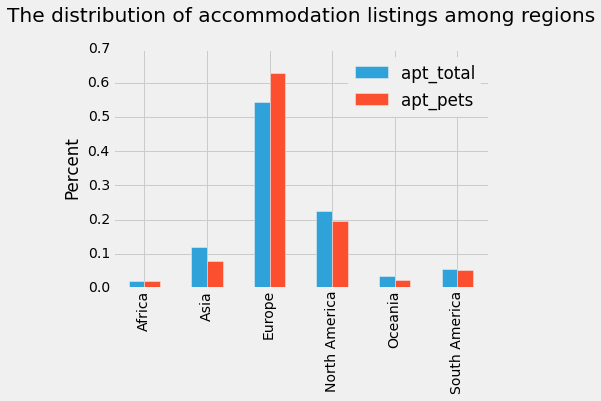

In [46]:
# Make a bar chart
plt.figure();
region_listings.plot(kind='bar')
plt.xlabel('')
plt.ylabel('Percent')
plt.title('The distribution of accommodation ' 
          'listings among regions \n')
plt.show()

The plot and the table above reveal that the highest percentage of Airbnb listings (54.4%) are located in Europe. The European share of global PFL reaches 63%. Americas region lags behind with 27.8% share. 

Not only listings are distributed unevenly. The average price per night differes greatly in every region.

In [47]:
region_price = df_cut.groupby(df_cut['region']).mean()[['apt_total_price', 
                                         'apt_pets_price']]
# Calculate ratio of PFL price to general listing price. 
region_price['ratio'] = region_price['apt_pets_price'] / region_price['apt_total_price']
region_price.sort('apt_total_price')

,apt_total_price,apt_pets_price,ratio
region,,,
South America,66.416667,73.500000,1.106650
Africa,66.787879,63.666667,0.953267
Asia,73.219512,77.951220,1.064624
Europe,79.695652,82.086957,1.030005
Oceania,117.666667,113.666667,0.966006
North America,270.794872,172.846154,0.638292


The cheapest region in terms of accommodation is Africa. Staying with a pet would cost even less - just $66 a night.

In Asia, price for a listing is rather low and equals $78, however pet allowance adds 40% to the average price. That is more expensive than a PFL in Europe. 

In Europe to stay with a pet would cost 15% more. But in any case this price is lower than in Oceania and Americas. 

Americas is the most expensive region to rent an apartment with average price reaching $218. Luxury apartments in Americas close theis doors to pet owners. That lowers the average price for a PFL to 32% but it's still the highest among regions. 

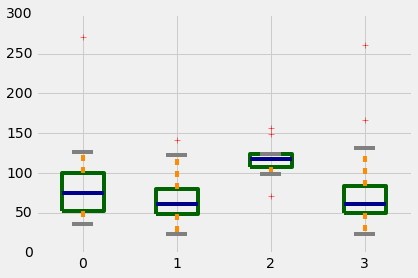

In [49]:
color = dict(boxes='DarkGreen', whiskers='DarkOrange',
             medians='DarkBlue', caps='Gray')
b_df = df_cut.groupby(['region'])[['apt_total_price']]
eu = b_df.get_group('Europe')
af = b_df.get_group('Africa')
# am = b_df.get_group('Americas')
oc = b_df.get_group('Oceania')
ai = b_df.get_group('Asia')
abr = pd.concat([eu, af, oc, ai], ignore_index=True, axis=1)
abr.plot(kind='box', color=color, sym='r+')

### Country overview
Ok, so now we know that Europe is a region to go with a pet. It provides the biggest number of PFL, though price is 7% higher for a pet friendly place. In which European countries hosts would welcome guests with pets?

In [77]:
import folium
from folium.utilities import split_six

print folium.__version__

0.2.0.dev


In [97]:
columns=['country_code', 'apt_total']
color_data = df2.set_index(columns[0])[columns[1]].to_dict()

{u'ABW': 811,
 u'AFG': 4,
 u'AGO': 24,
 u'AIA': 186,
 u'ALA': 18,
 u'ALB': 931,
 u'AND': 405,
 u'ARE': 2761,
 u'ARG': 12433,
 u'ARM': 1169,
 u'ASM': 3,
 u'ATA': 17,
 u'ATG': 204,
 u'AUS': 55491,
 u'AUT': 10438,
 u'AZE': 269,
 u'BDI': 13,
 u'BEL': 11424,
 u'BEN': 78,
 u'BES': 250,
 u'BFA': 55,
 u'BGD': 146,
 u'BGR': 4101,
 u'BHR': 37,
 u'BHS': 791,
 u'BIH': 1712,
 u'BLM': 516,
 u'BLR': 2077,
 u'BLZ': 658,
 u'BMU': 139,
 u'BOL': 474,
 u'BRA': 57482,
 u'BRB': 1334,
 u'BRN': 37,
 u'BTN': 12,
 u'BWA': 47,
 u'CAF': 2,
 u'CAN': 49068,
 u'CCK': 4,
 u'CHE': 13357,
 u'CHL': 9045,
 u'CHN': 24401,
 u'CIV': 133,
 u'CMR': 105,
 u'COD': 32,
 u'COG': 10,
 u'COK': 122,
 u'COL': 10171,
 u'COM': 2,
 u'CPV': 489,
 u'CRI': 6680,
 u'CUB': 2919,
 u'CUW': 720,
 u'CXR': 3,
 u'CYM': 161,
 u'CYP': 3618,
 u'CZE': 8607,
 u'DEU': 63917,
 u'DJI': 3,
 u'DMA': 233,
 u'DNK': 22977,
 u'DOM': 4516,
 u'DZA': 240,
 u'ECU': 3325,
 u'EGY': 1259,
 u'ERI': 1,
 u'ESH': 1,
 u'ESP': 120639,
 u'EST': 1468,
 u'ETH': 164,
 u'FIN': 3

In [85]:
geo_json_data = json.load(open('countries.geo.json'))

{u'type': u'FeatureCollection', u'features': [{u'geometry': {u'type': u'Polygon', u'coordinates': [[[61.210817, 35.650072], [62.230651, 35.270664], [62.984662, 35.404041], [63.193538, 35.857166], [63.982896, 36.007957], [64.546479, 36.312073], [64.746105, 37.111818], [65.588948, 37.305217], [65.745631, 37.661164], [66.217385, 37.39379], [66.518607, 37.362784], [67.075782, 37.356144], [67.83, 37.144994], [68.135562, 37.023115], [68.859446, 37.344336], [69.196273, 37.151144], [69.518785, 37.608997], [70.116578, 37.588223], [70.270574, 37.735165], [70.376304, 38.138396], [70.806821, 38.486282], [71.348131, 38.258905], [71.239404, 37.953265], [71.541918, 37.905774], [71.448693, 37.065645], [71.844638, 36.738171], [72.193041, 36.948288], [72.63689, 37.047558], [73.260056, 37.495257], [73.948696, 37.421566], [74.980002, 37.41999], [75.158028, 37.133031], [74.575893, 37.020841], [74.067552, 36.836176], [72.920025, 36.720007], [71.846292, 36.509942], [71.262348, 36.074388], [71.498768, 35.6505

In [107]:
from folium.utilities import split_six, color_brewer
from folium.features import ColorScale
"""
m.choropleth(geo_str=open('countries.geo.json').read(),
             data=df2,
             columns=['country_code', 'apt_total'],
             key_on='feature.id',
             fill_color='YlGn',
             threshold_scale=split_six(df2['apt_total'])
            )
"""
m = folium.Map([43, -40], zoom_start=2)
color_domain=split_six(df2['apt_total'])
fill_color='YlGn'
color_range = color_brewer(fill_color, n=len(color_domain))
print color_domain
print color_range
columns=['country_code', 'apt_total']
color_data = df2.set_index(columns[0])[columns[1]].to_dict()
key_on = 'id'

def get_by_key(obj, key):
    if len(key.split('.')) <= 1:
        return obj.get(key, None)

def color_scale_fun(x):
    try:
        shit = [u for u in color_domain if u <= color_data[get_by_key(x,key_on)]]
        return color_range[len(shit)]
    except KeyError:
        return '#FFFFFF'

folium.GeoJson(geo_json_data,
              style_function=lambda feature: {
                  'fillColor': color_scale_fun(feature),
                  'color': 'black',
                  'weight': 1,
                  'fillOpacity': 0.8
              }).add_to(m)

color_scale = ColorScale(color_domain, fill_color, caption="Bla bla bla")
m.add_children(color_scale)
m

[1.0, 300.0, 4000.0, 10000.0, 20000.0]
['#FFFFCC', '#D9F0A3', '#ADDD8E', '#78C679', '#41AB5D', '#238443', '#005A32']
